In [1]:
import pathlib
import utils
import os



# for idx, path in enumerate(inputs):
    
#     new="img_"+str(idx+1)+".jpg"
#     os.rename(path,new)
# os.chdir("D:/Cogniquest_internship/Code/Images")
# os.chdir("D:/Cogniquest_internship/Code")

In [9]:
os.chdir("D:/Cogniquest_internship/Code")
os.curdir

'.'

In [10]:
#Configurations 

import torch 
BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 5 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASSES = ['Atmospheric pressure limitation', 'Authorized Representative', 'Batch Code', 'Biological risks', 'Catalogue Number', 'Caution', 'Consult instructions', 'Contains Latex', 'Contains sufficient for -n- tests', 'Control', 'Date of Manufacture', 'Do not resterilize', 'Do not reuse', 'Do not use if package is damaged', 'Drops per milliliter', 'Fluid Path', 'For IVD perfomance evaluation only', 'Fragile Handle with care', 'Humidity Limitation', 'In vitro Diagnostic Medical device', 'Keep Dry', 'Keep away from sunlight', 'Liquid filter with pore size', 'Lower limit of temperature', 'Manufacturer', 'Negative Control', 'Non Pyrogenic', 'Non sterile', 'One way valve', 'Patient Number', 'Positive Control', 'Protect from heat radioactive sources', 'Sampling site', 'Sterile Fluid Path', 'Sterile', 'Sterilized using aseptic techniques', 'Sterilized using ethylene oxide', 'Sterilized using irradiation', 'Sterilized using steam', 'Temperature Limit', 'Upper limit of temperature', 'Use By Date']
NUM_CLASSES=42
TRAIN_DIR = 'D:/Cogniquest_internship/Code/train'

    

In [11]:
#Models 
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model


In [16]:
#Dataset
import torch
import cv2
import numpy as np
import os
import glob as glob
import albumentations as A

from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
class MicrocontrollerDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# prepare the final datasets and data loaders
train_dataset = MicrocontrollerDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Number of training samples: {len(train_dataset)}")


if __name__ == '__main__':
    # sanity check of the Dataset pipeline with sample visualization
    dataset = MicrocontrollerDataset(
        TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
    )
    print(f"Number of training images: {len(dataset)}")
    
    def visualize_sample(image, target):
        box = target['boxes'][0]
        label = CLASSES[target['labels']]
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 2
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        
    NUM_SAMPLES_TO_VISUALIZE = 5
    for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = dataset[i]
        visualize_sample(image, target)

Number of training samples: 42
Number of training images: 42


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [6]:
#utils 

import cv2
import numpy as np

from albumentations.pytorch import ToTensorV2
classes=CLASSES
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })


def show_tranformed_image(train_loader):
    
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scikit (from versions: none)
ERROR: No matching distribution found for scikit



EPOCH 1 of 5
Training


  0%|          | 0/11 [00:00<?, ?it/s]

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


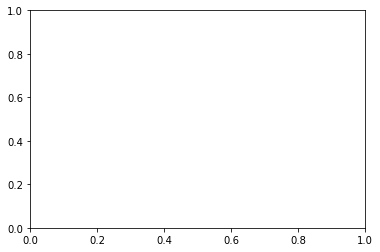

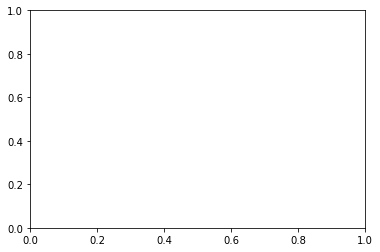

In [18]:
#Engine 
from tqdm.auto import tqdm


import torch
import matplotlib.pyplot as plt
import time
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list


if __name__ == '__main__':
    
    model = create_model(num_classes=NUM_CLASSES)
    model = model.to(DEVICE)

    params = [p for p in model.parameters() if p.requires_grad]
    
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

    
    train_loss_hist = Averager()
    val_loss_hist = Averager()
    train_itr = 1
    val_itr = 1
    
    train_loss_list = []
    val_loss_list = []

    
    MODEL_NAME = 'model'

    
    

    for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

       
        train_loss_hist.reset()
        val_loss_hist.reset()

        
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()

  
        start = time.time()
        train_loss = train(train_loader, model)
        val_loss = validate(valid_loader, model)
        print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
        print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

        if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
            torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
            print('SAVING MODEL COMPLETE...\n')
        
        if (epoch+1) % SAVE_PLOTS_EPOCH == 0: 
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('iterations')
            train_ax.set_ylabel('train loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('iterations')
            valid_ax.set_ylabel('validation loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
            print('SAVING PLOTS COMPLETE...')
        
        if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('iterations')
            train_ax.set_ylabel('train loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('iterations')
            valid_ax.set_ylabel('validation loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

            torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        
        plt.close('all')
        
        time.sleep(5)